In [1]:
from VariationalBayes import VectorParam, ScalarParam, PosDefMatrixParam, ModelParamsDict
import math

from autograd import grad, hessian, jacobian, hessian_vector_product
from autograd.core import primitive
from autograd.numpy.numpy_grads import unbroadcast

import autograd.numpy as np
import autograd.numpy.random as npr

import copy
import scipy
from scipy import optimize
from scipy import stats

In [2]:
def Log1mInvLogit(u):
    # log(1 - p) = log(1 / (1 + exp(u))) = -log(1 + exp(u))
    return -np.log1p(np.exp(u))

def Logistic(u):
    return np.exp(u) / (1 + np.exp(u))

In [88]:
N = 20000
K = 100

# Build an object to contain a variational approximation to a K-dimensional multivariate normal.
mvn_par = ModelParamsDict()

mvn_par.push_param(VectorParam('e_mu', K))
mvn_par.push_param(VectorParam('var_mu', K, lb=0))

mvn_par['e_mu'].set(np.full(K, 0.1))
mvn_par['var_mu'].set(np.full(K, 2.))

# Generate data
true_mu = np.random.rand(K) - 0.5
x_mat = np.full([N, K], float('nan'))
y_vec = np.full([N], float('nan'))
x_mat = np.random.random(K * N).reshape(N, K) - 0.5
# true_rho = Logistic(np.dot(x_mat[n, :], true_mu))
true_rho = Logistic(np.matmul(x_mat, true_mu))
y_vec = np.random.random(N) < true_rho


In [89]:
def LogLikelihoodVectorized(x_mat, y_vec, e_mu, mu_var, std_draws):
    rho_sd = np.sqrt(np.einsum('ik,ik,k->i', x_mat, x_mat, mu_var))
    rho_mean = np.einsum('ij,j->i', x_mat, e_mu)
    z = np.einsum('i,j->ij', rho_sd, std_draws) + np.expand_dims(rho_mean, 1)

    # The sum is over observations and draws, so dividing by the draws size
    # gives the sum of sample expectations over the draws.
    # log(1 - p) = log(1 / (1 + exp(u))) = -log(1 + exp(u))
    logit_term = -np.sum(np.log1p(np.exp(z))) / std_draws.size
    y_term = np.sum(y_vec * rho_mean)
    return y_term + logit_term


def UnivariateNormalExpectedEntropy(var_mu):
    return 0.5 * np.sum(np.log(var_mu))


def Elbo(y_vec, x_mat, mvn_par_elbo, num_draws=10):
    var_mu = mvn_par_elbo['var_mu'].get()
    e_mu = mvn_par_elbo['e_mu'].get()

    num_draws = 10
    draw_spacing = 1 / float(num_draws + 1)
    target_quantiles = np.linspace(draw_spacing, 1 - draw_spacing, num_draws)
    std_draws = scipy.stats.norm.ppf(target_quantiles)

    assert y_vec.size == x_mat.shape[0]
    assert e_mu.size == x_mat.shape[1]

    ll = LogLikelihoodVectorized(x_mat, y_vec, e_mu, var_mu, std_draws)
    entropy = 0.5 * np.sum(np.log(var_mu))
    #entropy = UnivariateNormalExpectedEntropy(var_mu)

    return ll + entropy


class KLWrapper():
    def __init__(self, mvn_par, x_mat, y_vec, num_draws):
        self.__mvn_par_ad = copy.deepcopy(mvn_par)
        self.x_mat = x_mat
        self.y_vec = y_vec
        self.num_draws = num_draws
        
    def Eval(self, free_par_vec, verbose=False):
        self.__mvn_par_ad.set_free(free_par_vec)
        kl = -Elbo(self.y_vec, self.x_mat, self.__mvn_par_ad, num_draws=self.num_draws)
        if verbose: print kl
        return kl
    
    # Return a posterior moment of interest as a function of
    # unconstrained parameters.  In this case it is a bit silly,
    # but in full generality posterior moments may be a complicated
    # function of moment parameters.
    def GetMu(self, free_par_vec):
        self.__mvn_par_ad.set_free(free_par_vec)
        return self.__mvn_par_ad['e_mu'].get()



In [90]:
kl_wrapper = KLWrapper(mvn_par, x_mat, y_vec, 10)
KLGrad = grad(kl_wrapper.Eval)
KLHess = hessian(kl_wrapper.Eval)
MomentJacobian = jacobian(kl_wrapper.GetMu)
KLHessVecProd = hessian_vector_product(kl_wrapper.Eval)  

# Check that the AD functions are working:
mvn_par['e_mu'].set(true_mu)
mvn_par['var_mu'].set(np.abs(true_mu) * 0.1)
free_par_vec = mvn_par.get_free()
print kl_wrapper.Eval(free_par_vec)
if K < 10:
    print 'Grad:'
    print KLGrad(free_par_vec)
    print 'Hess:'
    print KLHess(free_par_vec)
    print 'Jac:'
    print MomentJacobian(free_par_vec)
    print 'Hess vector product:'
    print KLHessVecProd(free_par_vec, free_par_vec + 1)


101654.999286


In [91]:
par_mat = np.vstack((free_par_vec + 1, free_par_vec + 2)).T

# This is probably actually not necessary, since scipy.sparse.linalg.cg
# can't handle matrices on the RHS
def KLHessVecProdMat(par, mat):
    if len(mat.shape) == 1:
        return KLHessVecProd(par, mat)
    elif len(mat.shape) == 2:
        return np.array([ KLHessVecProd(par, mat_col) for mat_col in mat.T ]).T
    else:
        assert False

foo = KLHessVecProdMat(free_par_vec, par_mat)
print foo.shape

foo = KLHessVecProdMat(free_par_vec, free_par_vec)
print foo.shape

(200, 2)
(200,)


In [92]:
import timeit

time_num = 10

print 'Function time:'
print timeit.timeit(lambda: kl_wrapper.Eval(free_par_vec), number=time_num) / time_num

print 'Grad time:'
print timeit.timeit(lambda: KLGrad(free_par_vec), number=time_num) / time_num

print 'Hessian vector product time:'
print timeit.timeit(lambda: KLHessVecProd(free_par_vec, free_par_vec + 1), number=time_num) / time_num

# so slow
# print 'Hessian time:'
# print timeit.timeit(lambda: KLHess(free_par_vec), number=time_num) / time_num


Function time:
0.0134649991989
Grad time:
0.0183876037598
Hessian vector product time:
0.0381556034088


In [93]:
import cProfile

profile = False
if profile:
    cProfile.run('kl_wrapper.Eval(free_par_vec)', '/tmp/cprofilestats_func.prof')
    cProfile.run('KLHess(free_par_vec)', '/tmp/cprofilestats_hess.prof')
    cProfile.run('KLGrad(free_par_vec)', '/tmp/cprofilestats_grad.prof')

# A better way to visualize this https://jiffyclub.github.io/snakeviz/
# snakeviz /tmp/cprofilestats_hess.prof

In [94]:
# Set initial values.
xtx = np.matmul(x_mat.T, x_mat)
mu_reg = np.linalg.solve(xtx, np.matmul(x_mat.T, y_vec))

mvn_par['e_mu'].set(mu_reg)
mvn_par['var_mu'].set(np.full(K, 1.))
init_par_vec = mvn_par.get_free()

In [95]:
# Optimize.
# print 'Running BFGS'
# vb_opt_bfgs = optimize.minimize(
#     lambda par: kl_wrapper.Eval(par, verbose=True), init_par_vec,
#     method='bfgs', jac=KLGrad, tol=1e-2)

print 'Running Newton Trust Region'
vb_opt = optimize.minimize(
    lambda par: kl_wrapper.Eval(par, verbose=True),
    init_par_vec, method='trust-ncg', jac=KLGrad, hessp=KLHessVecProd)
mvn_par_opt = copy.deepcopy(mvn_par)
mvn_par_opt.set_free(vb_opt.x)
print 'Done.'

Running Newton Trust Region
23602.661695
22325.8457097
20272.578208
17879.6258206
15171.4014196
13304.7744595
13230.6174922
12752.5424587
12613.2764843
12581.5696674
12577.942532
12577.9399742
12577.8536995
12577.8536312
12577.8536312
Done.


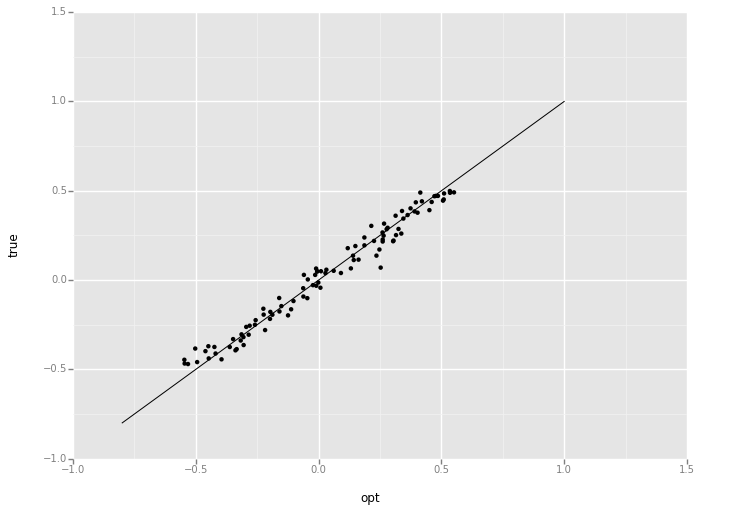

<ggplot: (8765819112369)>

In [96]:
# The mean parameters match, as expected.
from ggplot import *
import pandas as pd
%matplotlib inline

plot_df = pd.DataFrame({ 'opt': mvn_par_opt['e_mu'].get(), 'true': true_mu })
ggplot(plot_df, aes(x='opt', y='true')) + geom_point() + geom_abline(slope=1, intercept=0)

In [97]:
# LRVB with conjugate gradient
from scipy.sparse.linalg import LinearOperator
import sys

# The we will actually compute Hess^1 * moment_jac.T, leading to perhaps confusing
# naming of "columns".  
moment_jac = MomentJacobian(vb_opt.x)
ObjHessVecProdLO = LinearOperator((vb_opt.x.size, vb_opt.x.size), lambda par: KLHessVecProd(vb_opt.x, par))
# print moment_jac.T.shape
# print ObjHessVecProdLO.shape
# cg_res, info = scipy.sparse.linalg.cg(ObjHessVecProdLO, moment_jac.T)

lrvb_term = np.full(moment_jac.T.shape, float('nan'))
for col in range(moment_jac.shape[0]):
    sys.stdout.write('.')
    sys.stdout.flush()
    cg_res, info = scipy.sparse.linalg.cg(ObjHessVecProdLO, moment_jac[col, :])
    assert info == 0
    lrvb_term[:, col] = cg_res

print 'all done dude'

....................................................................................................all done dude


In [98]:
# Slow:
kl_hess = KLHess(vb_opt.x)

In [99]:
mu_cov_hess = np.matmul(moment_jac, np.linalg.solve(kl_hess, moment_jac.T))
mu_cov = np.matmul(moment_jac, lrvb_term)
print np.diag(mu_cov)
print np.diag(mu_cov_hess)
print mvn_par_opt['var_mu']

[ 0.00284416  0.00286912  0.00287637  0.00287682  0.00284165  0.00286885
  0.00285934  0.00284758  0.00282633  0.00286925  0.00288458  0.00286016
  0.00289905  0.00287725  0.00285356  0.00283478  0.00287995  0.00287809
  0.00286405  0.00288172  0.00286307  0.00285648  0.00283526  0.00291228
  0.00286341  0.00288717  0.00287796  0.00286688  0.00287234  0.00286357
  0.00286109  0.00286397  0.00285351  0.00284869  0.00283458  0.00285438
  0.0028324   0.00286     0.00287161  0.00287528  0.00283912  0.00286269
  0.00286292  0.00287878  0.00286473  0.00285693  0.00288422  0.002857
  0.00286255  0.00285194  0.00286416  0.00288683  0.00284329  0.00285612
  0.00290285  0.0028063   0.00289923  0.00288332  0.00287433  0.00282066
  0.00283272  0.00285926  0.00286616  0.00289416  0.00283471  0.00284745
  0.00287565  0.00284407  0.0028767   0.00285967  0.00287059  0.00285314
  0.0028528   0.00289753  0.00287626  0.00286175  0.00285053  0.00287244
  0.00287698  0.00288488  0.00285302  0.00286927  0.0